# Bootstrap example for Stroke data from pp. 3-5 of Efron & Tibshirani

RTB wrote it 29 October 2016 (derived from BS_ex1.m)
RTB modified it 30 Jan 2017: combined etASAhypoth.m and etASAstats.m into
one file that is modular for my stats class.
RTB modified it to emphasize stroke data (13 September 2018). ERBB translated to Python 08 September 2021. JP added short pandas intro Aug 2022. 

**The scenario**:

 A study was done to see if low-dose aspirin would prevent
heart attacks in healthy middle-aged men. The study design was optimal:
controlled, randomized, double-blind. Subjects were randomly assigned to
receive aspirin (ASA) or placebo. The summary statistics:

aspirin group (n=11037): 104 heart attacks (MI); 10933 no MI
placebo group (n=11034): 189 heart attacks; 10845 no MI

Scientific question #1: Does aspirin help to prevent heart attacks?

In the same study, the researchers also recorded the number of strokes in
each group:

aspirin group (n=11037): 119 strokes; 10918 without stroke
placebo group (n=11034): 98 strokes; 10936 without stroke

Scientific question #2: Does aspirin increase the risk of having a
stroke?

We will start by addressing the 2nd question regarding strokes. The code
you generate here will then allow you to rapidly analyze the heart attack
data.

**What to do:** 

Login to learning catalytics and join the session for the
module entitled "ASA Bootstrap". You will answer a series of
questions based on the guided programming below. 

Read through the comments and follow the instructions provided.
In some cases you will be asked to answer a question, clearly indicated
by 'QUESTION'. In other cases, you be asked to supply missing code,
indicated by 'TODO'. The corresponding question in learning catalytics
will be indicated in parentheses (e.g. Q1). If there is no 'Q#'
accompanying a 'QUESTION' just type your answer into this script and
discuss it with your team. Once you have supplied the required code, you
can execute that section by mouse-clicking in that section (The sidebar will turn blue/green.) and then simultaneously hitting the 'ctrl' and 'enter'
keys (PC) or 'command' and 'enter' keys (Mac).


**Concepts covered:**
1. Test for proportions: odds ratio
2. Comparing resampling tests with Fisher's exact test
3. Std. error and confidence intervals through bootstrapping
4. Relationship between CI and hypothesis test
5. Permutation test for strong test of H0.
6. One-tailed vs. two-tailed tests.
7. CI with 'bootci' and an anonymous function
8. Making data tables with 'table' command


In [3]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
# Constants: these would normally be passed as arguments to a function

n_boot = 10000
my_alpha = 0.05

# useful numbers for stroke data
n_rx = 11037  # total number of patients in the treatment group (ASA)
n_stroke_rx = 119  # number of strokes in the treatment group
n_ctrl = 11034  # total number of patients in the control group (placebo)
n_stroke_ctrl = 98  # number of strokes in the control group
n_total = n_rx + n_ctrl

## Short Pandas Intro (Python Only)

Until now, we have only been using Numpy for handling our data. This results in having to do slightly awkward things, like when we created variables to store column indices in week 2:
```
# Define cols
ID_COL = 0
GRE_COL = 1
GPA_COL = 2
```

In general, this is tedious, and it also forces us to keep track of all the data-handling logic ourselves. For instance, in the GRE data, what if we had another list that gave the country or state where each student had gone to high school? We would need to remember that variable name too! As we accumulated more data, it would become a nightmare. Luckily, for this reason we have tabular data!

In Python, the most commonly used tabular data format is called Pandas. As the [first tutorial](https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html#min-tut-01-tableoriented) on their site explains, in Pandas, "a DataFrame is a 2-dimensional data structure [a table] that can store data of different types (including characters, integers, floating point values, categorical data and more) in columns." This makes it incredibly flexible and powerful.

Here we will demonstrate a few of the typical usage cases you'll need for the rest of this class. Don't hesitate to come back to browse the [user guide](https://pandas.pydata.org/docs/user_guide/index.html) or their [full documentation ](https://pandas.pydata.org/docs/reference/index.html) or just google search "pandas XYZ" where XYZ is the operation you want! Feel free to skip this section if you're familiar with Pandas.

In [59]:
# Generate some fake data
names = ['Alice', 'Bob', 'Cathy', 'Donald']
ages = [10, 20, 30, 40]
gre_scores = [500, 600, 700, 650]
df = pd.DataFrame({'names': names, 'ages': ages, 'gre_scores': gre_scores})
df.head()  # .head() shows the first 5 rows of a DataFrame

,names,ages,gre_scores
0,Alice,10,500
1,Bob,20,600
2,Cathy,30,700
3,Donald,40,650


Notice that both the rows and the columns are named. The rows have been named 0,1,2,3 by default, since we didn't provide anything else; and the columns have been given the names that we put in the dictionary above when we made the DataFrame using `pd.DataFrame()`. These names are also called the DataFrame's indexes. An index is actually a very special thing in Pandas, which we won't worry about too much, but just know that if you want to see all the values of an index, you can do this:

In [22]:
df.index.values  # df.index implicitly refers to the row index

array([0, 1, 2, 3])

If you want to see all the column names you can do:

In [60]:
df.columns.values  # also technically an "index" object, but called columns for clarity

array(['names', 'ages', 'gre_scores'], dtype=object)

### Extracting data

How do you work with data in a DataFrame? Your first instinct to access data in a DataFrame might be to do something like `df[0,1]` (if you wanted to know Alice's age [0th row, 1st column]). However, this will raise an error -- go ahead and try it.

In [ ]:
df[0,1]  # raises an error

This is because DataFrames are not quite as simple as Numpy arrays!

Instead, there are three main ways to access data in a Pandas dataframe. We will explain each. 

**Working with columns**

The first is by using "dot" or "bracket" notation to access individual columns. The columns are then indexed in a straightforward way. Whether to use dot or bracket notation largely depends on personal preference. Strictly speaking, bracket notation is better because it is guaranteed to work — e.g. if the column name contains a space, dot notation won't work — but I prefer dot notation because it's faster to type, and so all my column names have underscores.

In [73]:
print('Dot notation:')
print(df.gre_scores)
print()

print('Bracket notation:')
print(df['gre_scores']) # same thing as df.gre_scores
print()

print('Multiple cols with bracket notation:')
print(df[['gre_scores', 'ages']])  # we can get multiple columns with a list of column names
print()

print(f'Alice\'s GRE score: {df.gre_scores[0]}')  # easy zero-based indexing within a column

Dot notation:
0    500
1    600
2    700
3    650
Name: gre_scores, dtype: int64

Bracket notation:
0    500
1    600
2    700
3    650
Name: gre_scores, dtype: int64

Multiple cols with bracket notation:
   gre_scores  ages
0         500    10
1         600    20
2         700    30
3         650    40

Alice's GRE score: 500


In [16]:
older_than_20 = df.names[df.ages > 20]  # Boolean indexing works equally well here as in numpy
older_than_20

2     Cathy
3    Donald
Name: names, dtype: object

*Warning*: Notice that the output `older_than_20` still has the original index values (2 and 3) associated with it. If this is ever causing bugs in your code you can always reset the index:

In [27]:
older_than_20 = older_than_20.reset_index(drop=True)
older_than_20

0     Cathy
1    Donald
Name: names, dtype: object

**Working with rows and columns: loc**

The second method is using the `.loc` method. This allows you to access data by row and column index. This example makes more sense if we use the names for an index, so we will change it. For example:

In [74]:
df = df.set_index('names')
df.head()

,ages,gre_scores
names,,
Alice,10,500
Bob,20,600
Cathy,30,700
Donald,40,650


In [34]:
df.loc['Alice', 'gre_scores']

500

In [35]:
df.loc[df.ages > 20, 'gre_scores']  # boolean indexing also works here

names
Cathy     700
Donald    650
Name: gre_scores, dtype: int64

**iloc**

The third method is the `.iloc` method. This allows you to use the integer-position of the row to select. This is essentially the same as having the index be 0,1,2,3... but in cases where you have a more meaningful index, this can be helpful if you want to know the i-th entry:

In [39]:
df.iloc[0,1]

500

In general, you can avoid iloc with various combinations of the first two.

### A few other useful points

Pandas has many built in simple statistics. For example:

In [50]:
print('Sums:')
print(df.sum())
print()

print('Means:')
print(df.mean())
print()

print('Variances:')
print(df.var())

Sums:
ages           100
gre_scores    2450
dtype: int64

Means:
ages           25.0
gre_scores    612.5
dtype: float64

Variances:
ages           166.666667
gre_scores    7291.666667
dtype: float64


##  Calculate the actual ratio of rates of disease: an odds ratio

Ok, back to statistics! 

The odds ratio is defined as the ratio of 2 ratios: the numerator is the ratio of
the number of subjects in the treatment group who had a stroke divided by
the number who did not have a stroke. The denominator is the same, but
for the control group.


In [57]:
# TODO: calculate the odds ratio for this study
or_hat = ...

print(or_hat)

1.2162876507994662


**QUESTION (Q1)**: What is your odds ratio to 4 decimal places?


## Create a population from which to resample:

The general approach in bootstrapping is to resample from our *original
sample*. But you've been given only proportions, so you have to
*re-create* the raw data based on the proportions. It's alarmingly
simple, but you might have to think about it for a bit. (Note that we won't use the tidy format here to sync better with Matlab)

HINT: You should be able to re-calculate your original odds ratio with this formula:
`( data['rx_grp'].sum() / (data['rx_grp'] == 0).sum() ) / ( data['ctrl_grp'].sum() / (data['ctrl_grp'] == 0).sum() )`. Notice the use of bracket notation to access the columns, and the .sum() method to get the sum of each column.

THINK: what does it mean when we call `.sum()` on the result of `(data['rx_grp'] == 0)`, which would be a boolean? If you're not sure, try some simple examples!

In [51]:
n_rows = np.max([n_ctrl, n_rx])

data = pd.DataFrame({'ctrl_grp': np.nan * np.ones((n_rows,)),
                     'rx_grp': np.nan * np.ones((n_rows, )) })

# TODO: recreate the raw data
...



data.head()

,ctrl_grp,rx_grp
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [52]:
( data['rx_grp'].sum() / (data['rx_grp'] == 0).sum() ) / ( data['ctrl_grp'].sum() / (data['ctrl_grp'] == 0).sum() )

1.2162876507994662

Note that we have some NaNs to make these columns the same size. To grab the non-Nan data, which you'll need to do below, use `data['ctrl_grp'].dropna()`

## Generate bootstrap replicates of the odds ratio


In [55]:
# holds each bootstrap calc. of the odds ratio
or_bootstrap = pd.DataFrame({'or_star': np.zeros((n_boot,))}) 

# set random seed
np.random.seed(123)

for k in range(n_boot):

    # TODO: Re-sample from each group WITH REPLACEMENT to create two new
    # samples: rx_star and ctrl_star. Then use these two bootstrap samples to
    # calculate an odds ratio and store it in or_bootstrap['or_star']
    rx_star = ...
    ctrl_star = ...
    or_bootstrap.loc[k, 'or_star'] = ...                                   

## Make a histogram of our bootstrap replicates of OR

Here, we also introduce seaborn (imported as `sns`), a plotting package that is basically a fancy wrapper for matplotlib that works easily with Pandas DataFrames.

In general, seaborn expects you to be plotting different columns of a DataFrame against each other, or making histograms out of single columns. Trying to do anything else will result in frustration and you should just make the plot manually!

For most seaborn functions (which you can browse in a beautiful gallery [here](https://seaborn.pydata.org/examples/index.html)), the syntax is:
```
sns.plotting_function(data = my_pandas_dataframe, x = "column_1", y = "column_2")


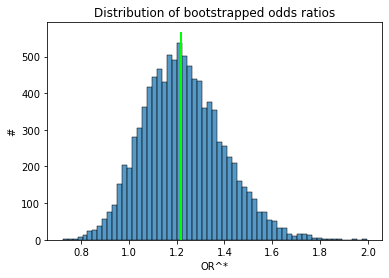

In [58]:
fig, ax = plt.subplots(1, 1)

sns.histplot(data = or_bootstrap, x = 'or_star', ax = ax)  # no "y" argument since histograms only have one data axis

ax.plot([or_hat, or_hat], ax.get_ylim(), 'lime', lw = 2)
ax.set(xlabel = 'OR^*',
       ylabel = '#',
       title = 'Distribution of bootstrapped odds ratios');

## Calculate the standard error and the confidence intervals


In [ ]:
# TODO: Compute the bootstrap estimate of the standard error of the odds ratio
sem_boot = ...

sem_boot

0.16751545118201397

**QUESTION (Q2)**: What is bootstrap estimate of the standard error of the odds ratio?

In [ ]:
# TODO: Use the percentile method to determine the 95% confidence interval.
...

conf_interval = [or_star_sorted.iloc[idx_lo], or_star_sorted.iloc[idx_hi]]

print(conf_interval)

[0.9312649586702508, 1.5868725868725868]


**QUESTION (Q3)**: What is the 95% CI based on your bootstrap distribution?

**QUESTION (Q4)**: What is the null value of the odds ratio?

**QUESTION (Q5)**: How can we use the known null value of the odds ratio to
perform a hypothesis test?

**QUESTION (Q6)**: Can we reject H0 at an alpha of 0.05?


## Plot CIs on histogram


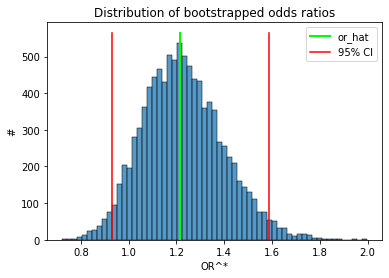

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.histplot(data = or_bootstrap, x = 'or_star');

ylims = ax.get_ylim()

ax.plot([or_hat, or_hat], ylims, 'lime', lw = 2, label = 'or_hat')

# Add CIs
ax.plot([conf_interval[0], conf_interval[0]], ylims, 'r', label = '95% CI')
ax.plot([conf_interval[1], conf_interval[1]], ylims, 'r')

ax.legend()

ax.set(xlabel = 'OR^*',
       ylabel = '#',
       title = 'Distribution of bootstrapped odds ratios');

## Bonus: 2-sided p-value from the bootstrap distribution

We can get a more exact 2-sided p-value by gradually shrinking our CI
until the null value falls just outside. We have already done the hard
work of generating the bootstrap distribution and sorting it, so now we
just loop through and find the value of alpha that puts the null value of
1 outside of the lower bound.

NOTE: In the code below, we are taking advantage of our prior knowledge
that it is the lower bound of the CI that we should be testing. But
realize that we are effectively *shrinking* the CI in the 'while' loop:
the upper bound of the CI would be decreasing, just as the lower bound is
increasing. We just aren't bothering to calculate it, because it doesn't
matter. If our calculated odds ratio was below 1, then we would test the
upper bound as we shrunk the CI.


NOTE: This cell won't work for the MI data, since our bootstrapped distribution won't contain the null value.

In [ ]:
ci_low = conf_interval[0]
p_alpha = my_alpha
    
while ci_low < 1:

    # increment alpha
    p_alpha += 0.001
    
    # calculate new index corresponding to lower %ile:
    idx_lo = np.floor(( p_alpha / 2 ) * n_boot).astype('int')
    
    # grab the corresponding value from our sorted bootstrap distribution
    ci_low = or_star_sorted[idx_lo]

print(p_alpha)

0.1630000000000001


## Perform an explicit hypothesis test by modeling our OR under H0

In this case, we will use a permutation test, where we resample WITHOUT
replacement. The logic is that we are essentially randomly assigning each
patient to the treatment or control group, then recalculating our odds
ratio. Here, we are testing the most extreme version of H0, which is that
the two distributions are the SAME.



In [ ]:
# # TODO: Perform resampling as though the patients all belonged to the
# same group (called H0_data), shuffle this data, then arbitraily assign
# each patient to the treatment or control group and compute the odd ratio. 
# Store each bootstrapped odds ratio in orPerm

# Pool all the data:
H0_data = pd.concat([data['rx_grp'].dropna(), data['ctrl_grp'].dropna()])

# Place to store our results:
or_bootstrap['or_perm'] = np.zeros((n_boot,))

# Set random seed
np.random.seed(123)

# Loop over bootstraps
for k in range(n_boot):

    # Shuffle and assign to rx_star and ctrl_star (ALL values are used!)
    ...

    or_bootstrap.loc[k, 'or_perm'] = ...
    

## Plot the distrubtion of permuted ORs


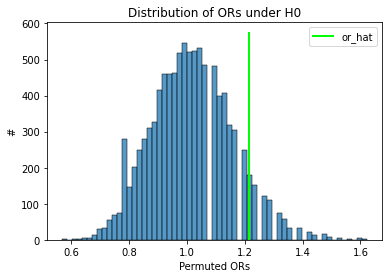

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.histplot(data = or_bootstrap, x = 'or_perm');

ylims = ax.get_ylim()

ax.plot([or_hat, or_hat], ylims, 'lime', lw = 2, label = 'or_hat')

ax.legend()

ax.set(xlabel = 'Permuted ORs',
       ylabel = '#',
       title = 'Distribution of ORs under H0');

## Calculate a 1-tailed p-value

In [ ]:
# TODO: Calculate a one-tailed p-value based on your permuted samples (i.e.
# or_perm) and store it in a variable called 'p_val_1t'
if or_hat < 1:
    p_val_1t = ...
else:
    p_val_1t = ...


# The p-value can never be 0. If it comes out zero, what should we set it to instead?
# (Ie, what is the most conservative estimate of the p-value in this case?)
if p_val_1t == 0:
    p_val_1t = ...

p_val_1t

0.0835

**QUESTION (Q7)**: What is our one-tailed p-value for the odds ratio?


## Calculate a 2-tailed p-value

In [ ]:
# TODO: Calculate a two-tailed p-value based on your permuted samples (i.e.
# or_perm) and store it in a variable called 'p_val_2t'
if or_hat < 1:
    p_val_2t = ...
else:
    p_val_2t = ...

if p_val_2t == 0:
    p_val_2t = ...

p_val_2t

0.1747

**QUESTION (Q8)**: What is our two-tailed p-value for the odds ratio?

Philosophical interlude: The difference in implementation between
2-tailed and 1-tailed p-value is pretty clear. The philosophical
difference, somewhat less. If you accidentally coded a 2-tailed test and
get a p value of, say,0.06, and then remember "Oh! A 1-tailed test was
actually more appropriate!" (and it really is in that instance, not for a
"p-hacky" reason) and obtain p ~ 0.03, there's a sudden shift in
perspective on the data. But it's the same data, and you're performing
more or less the same analysis. Does this seem even remotely reasonable?
This very subtle distinction would have a pretty heavy impact on a
statistics-naïve researcher. It can be helpful to think about edge cases
like this, where our arbitrary thresholding statistical procedure leads
to binarization of the same data into two categories which are
interpreted in very different ways, and how we should consider data of
this variety. Is it helpful to construct a new categorization, e.g.
"statistically significant (p small)," "unlikely to produce statistical
significance (p biggish)" and "of uncertain relationship (p kinda
small?)" or does that just move the problem?

See my article: https://www.eneuro.org/content/6/6/ENEURO.0456-19.2019

## Compare with the Fisher Exact Test for Stroke data


In [ ]:
import scipy.stats

table = np.array([[n_stroke_rx, n_rx - n_stroke_rx], 
                  [n_stroke_ctrl, n_ctrl - n_stroke_ctrl]])

# TODO: Calculate a 2-tailed p-value using Fisher's Exact Test
odds_ratio, p_val = ...

print(odds_ratio)
print(p_val)

1.2162876507994662
0.17229996732353314


This function doesn't return the confidence interval, unlike the Matlab version, so I implemented it myself below. See the equations [here](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717_ComparingFrequencies/PH717_ComparingFrequencies8.html).


In [ ]:
# Compute lower bound of 95% confidence interval

# Compute the standard error of odds ratio
se = np.sqrt( 1 / table[0, 0] + 1 / table[0, 1] + 1 / table[1, 0] + 1 / table[1, 1])

# Get the confidence interval
norm_inv = scipy.stats.norm.ppf((1 - my_alpha / 2))
conf_interval_fisher = [odds_ratio*np.exp(-norm_inv*se), odds_ratio*np.exp(norm_inv*se)]

print(conf_interval_fisher)

[0.9297260256964051, 1.5911737529119752]


**QUESTION (Q9)**: What p-value does Fisher's Exact Test give?

**QUESTION (Q10)**: What is the lower bound of the 95% CI from Fisher's Exact
Test?

Be sure to compare this with your values from the bootstrap!

**QUESTION (Q11)**: Save your final figure for the stroke data as a jpeg and
upload it to the LC site.


## Repeat calculations for the heart attack data

In [ ]:
# Useful numbers for heart attack data
n_rx = 11037  # number of patients in the treatment group (ASA)
n_MI_rx = 104  # number of heart attacks (= MIs) in the treatment group
n_ctrl = 11034  # number of patients in the control group (placebo)
n_MI_ctrl = 189  # number of MIs in the control group

# Generate the raw data
n_rows = np.max([n_ctrl, n_rx])

data = pd.DataFrame({'ctrl_grp': np.nan * np.ones((n_rows,)),
                     'rx_grp': np.nan * np.ones((n_rows, )) })

# TODO: create the raw data like before
...

data.head()

# Odds ratio for MI data
or_hat = ...

print(or_hat)

0.5458354566559084


**QUESTION (Q12)**: What is the odds ratio, `or_hat`, for the heart attack data?

TODO: Repeat the above analysis for the MI data. If you wrote
everything in terms of `rx_grp` and `ctrl_grp`, then once you've generated
the corresponding raw values for the MI data, you should be able to just
re-run cells below the first dataframe creation/odds ratio computation without further edits to your code.

**QUESTION (Q13)**: What is the bootstrap estimate of the 95% CI of the odds
ratio for the heart attack data?

**QUESTION (Q14)**: Can we reject H0 at an alpha of 0.05 for the heart attack data?

**QUESTION (Q15)**: Based on the permutation test, what is your 1-sided
p-value for the heart attack data?

Be sure to compare the confidence intervals that you obtain
through bootstrapping to those obtained with Fisher's Exact Test.

## Final thoughts on CIs and Hypothesis Testing

There is a beautiful and important section on the relationship between
confidence intervals and hypothesis tests in section 15.4 of E&T (p.
214). 

Look at the top half of your figure. Key question: What value of alpha
will make the lower end of the bootstrap confidence interval equal to 1?
It is just the probability mass of the bootstrap distribution to the left
of 1: sum(orStar <= 1) / nBoot. This gives us a bootstrap p-value of
0.0807. (Compare this with our 1-tailed permutation-based p-value of
0.0887.)

Compare the top and bottom halves and consider this statement from E&T
(p. 216): "In this sense, the permutation p-value measures how far the
observed estimate, orHat, is from 1, while the bootstrap p-value
measures how far 1 is from orHat." (Remember that 1 is our null value
for the odds ratio.)

Which test is preferred? In general, the permutation test is the most
rigorous way to test H0, since we are directly instantiating it by
"breaking" the relationship we seek to test. In this case, we are
randomly assigning the observed data to either the treatment or the
control group. As E&T point out (p. 216): "The permutation p-value is
exact, while the bootstrap p-value is approximate." They conclude with
what should become one of your statistical mantras (p. 218): "When there
is something to permute, it is a good idea to do so . . . ."
